In [1]:
from evaluation_script_pdss import *


2024-04-10 12:41:39.830881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 12:41:40.377452: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-10 12:41:40.377480: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-10 12:41:42.721800: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

In [4]:
len(gen_ground_truth_clean_cvp())

407

In [5]:
gen_ground_truth_clean_cvp()[0][0], gen_ground_truth_clean_cvp()[-1][1]

(1641439671, 1656498587)

In [4]:
window_size = 20
tolerance = 0
threshold = 0.5

stitched_predictions_abp, stitched_ground_truth_abp = get_predictions("abp", window_size, threshold = threshold, tolerance = tolerance)
stitched_predictions_cvp, stitched_ground_truth_cvp = get_predictions("cvp", window_size, threshold = threshold, tolerance = tolerance)


  0%|                                                                                                                                                                                                      | 0/8 [00:00<?, ?it/s]

random_window_2500.csv


  0%|                                                                                                                                                                                                      | 0/6 [00:00<?, ?it/s]

random_window_2500.csv


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:19<00:00, 13.25s/it]


In [5]:
print(len(stitched_predictions_abp[0]), len(stitched_ground_truth_abp[0]))
print(len(stitched_predictions_cvp[0]), len(stitched_ground_truth_cvp[0]))

print(len(stitched_predictions_abp[1]), len(stitched_ground_truth_abp[1]))
print(len(stitched_predictions_cvp[1]), len(stitched_ground_truth_cvp[1]))



394 284
880 406
713 297
1032 158


In [6]:
def calculate_summary_metrics(stitched_data, tolerance=30):
    
    tolerance = datetime.timedelta(hours=tolerance)
       # Combine and sort all predictions, converting epochs to datetime objects
    all_predictions = [(epoch_to_datetime(start), epoch_to_datetime(stop)) for region in stitched_data for start, stop in region]

    # Merge overlapping or closely spaced intervals
    merged_predictions = merge_intervals(all_predictions, datetime.timedelta(hours=12))

    time_to_first_pos = []
    frequency_of_pos = []  # To store frequency of positive events per minute for each region
    duration_of_pos = []
    

    for (region_start, region_end) in tqdm((merged_predictions)):  # Limit to the first 2 regions for testing

        first_pos = True
        pos_events_count = 0  

        for start, stop in stitched_data[0]:
            start_dt, stop_dt = epoch_to_datetime(start), epoch_to_datetime(stop)
            duration = (stop_dt - start_dt).total_seconds() / 3600
            
            if start_dt <= region_end and stop_dt >= region_start and duration > 0:
                if first_pos:
                    #time_to_first_pos.append(duration * 60)  # Convert hours to minutes
                    time_to_first_pos.append((start_dt-region_start).total_seconds() / 3600)
                    first_pos = False

                pos_events_count += 1  # Counting each positive event
                duration_of_pos.append(duration)
                
        # Calculate the total duration of the region in minutes
        total_duration_hours = (region_end - region_start).total_seconds() / 60 /60
        
        # Compute frequency of positive events per minute for the region
        if total_duration_hours > 0 and pos_events_count >0:  # Avoid division by zero
            frequency = pos_events_count / total_duration_hours
            frequency_of_pos.append(frequency)
    
    return time_to_first_pos, frequency_of_pos, duration_of_pos

def filter_and_summary(time_to_first_pos, frequency_of_pos, duration_of_pos, 
                       percentile_min_gap=5, percentile_max_gap=95, percentile_max_duration=99):
    """
    Filters metrics based on percentiles and computes summary statistics for non-filtered metrics.

    Parameters:
    - time_to_first_pos: list of times to first positive prediction in minutes.
    - frequency_of_pos: list of frequency between positive predictions in events/min.
    - duration_of_pos: list of durations of positive predictions in hours.
    - percentile_min_gap: percentile for minimum gap cutoff.
    - percentile_max_gap: percentile for maximum gap cutoff.
    - percentile_max_duration: percentile for maximum duration cutoff in minutes.

    Returns:
    - summaries: Tuple containing mean and standard deviation of non-filtered metrics.
    - filtered_metrics: Filtered metrics based on specified criteria.
    """
    
    # Determine percentile-based cutoffs
    min_gap_cutoff = np.percentile(time_to_first_pos, percentile_min_gap)
    max_gap_cutoff = np.percentile(frequency_of_pos, percentile_max_gap)
    max_duration_cutoff = np.percentile([duration * 60 for duration in duration_of_pos], percentile_max_duration)

    # Apply filtering based on percentile cutoffs
    filtered_time_to_first_pos = [time for time in time_to_first_pos if time <= max_gap_cutoff]
    filtered_freqs = [freq for freq in frequency_of_pos if min_gap_cutoff <= freq <= max_gap_cutoff]
    filtered_duration = [duration * 60 for duration in duration_of_pos if duration * 60 <= max_duration_cutoff]
    
    # Compute summary statistics for non-filtered metrics
    metrics = [time_to_first_pos, frequency_of_pos, [duration * 60 for duration in duration_of_pos]]
    summaries = [(np.mean(metric), np.std(metric)) for metric in metrics]
    
    # Prepare filtered metrics for plotting or further analysis
    filtered_metrics = [filtered_time_to_first_pos, filtered_freqs, filtered_duration]
    
    return summaries, metrics



def plot_data(metrics_abp_pred, metrics_abp_truth, metrics_cvp_pred, metrics_cvp_truth, titles):
    fig, axs = plt.subplots(1, len(titles), figsize=(20, 6))  # One row, number of metrics columns
    
    for i, title in enumerate(titles):
        data = [metrics_abp_truth[i], metrics_abp_pred[i], metrics_cvp_truth[i], metrics_cvp_pred[i]]
        bplot = axs[i].boxplot(data, patch_artist=True, positions=[1, 2, 4, 5], notch=True)
        
        # Set colors for each box
        colors = ['lightblue', 'lightgreen', 'lightblue', 'lightgreen']
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)
        
        axs[i].set_title(title)
        axs[i].set_xticks([1.5, 4.5])
        axs[i].set_xticklabels(['ABP', 'CVP'])
        
        # Creating custom legends
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='lightblue', label='Ground Truth'),
                           Patch(facecolor='lightgreen', label='Prediction')]
        axs[i].legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()


# Example usage
def plot_summary_metrics(stitched_predictions_abp, stitched_ground_truth_abp, stitched_predictions_cvp, stitched_ground_truth_cvp):
    # Calculate metrics
    metrics_abp_pred = calculate_summary_metrics(stitched_predictions_abp)
    metrics_abp_truth = calculate_summary_metrics(stitched_ground_truth_abp)
    metrics_cvp_pred = calculate_summary_metrics(stitched_predictions_cvp)
    metrics_cvp_truth = calculate_summary_metrics(stitched_ground_truth_cvp)
    
    # Filter and summarize
    summaries_abp_pred, filtered_metrics_abp_pred = filter_and_summary(*metrics_abp_pred)
    summaries_abp_truth, filtered_metrics_abp_truth = filter_and_summary(*metrics_abp_truth)
    summaries_cvp_pred, filtered_metrics_cvp_pred = filter_and_summary(*metrics_cvp_pred)
    summaries_cvp_truth, filtered_metrics_cvp_truth = filter_and_summary(*metrics_cvp_truth)
    
    # Assuming summaries_abp_pred, summaries_abp_truth, summaries_cvp_pred, summaries_cvp_truth are defined as before
    # Modification to create a DataFrame with mean and std in the same cell
    summaries = {
        'Metric': ['Time to First Pos', 'Frequency of Pos', 'Duration of Pos (Minutes)'],
        'ABP Predictions': [f"{mean:.2f} ± {std:.2f}" for mean, std in summaries_abp_pred],
        'ABP Ground Truth': [f"{mean:.2f} ± {std:.2f}" for mean, std in summaries_abp_truth],
        'CVP Predictions': [f"{mean:.2f} ± {std:.2f}" for mean, std in summaries_cvp_pred],
        'CVP Ground Truth': [f"{mean:.2f} ± {std:.2f}" for mean, std in summaries_cvp_truth],
    }

    df_summaries = pd.DataFrame(summaries)
    print(df_summaries)
    
    # Plot data
    plot_data(filtered_metrics_abp_pred, filtered_metrics_abp_truth,filtered_metrics_cvp_pred, filtered_metrics_cvp_truth, ['Filtered Freqs', 'Duration of Pos'])
    #plot_data(filtered_metrics_cvp_pred, filtered_metrics_cvp_truth, ['Time to First Pos', 'Filtered Gaps', 'Duration of Pos'])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 1863.35it/s]


                      Metric ABP Predictions ABP Ground Truth CVP Predictions  \
0          Time to First Pos     1.64 ± 3.24    27.55 ± 36.28     0.02 ± 0.07   
1           Frequency of Pos   15.47 ± 40.93      0.18 ± 0.07    5.34 ± 20.28   
2  Duration of Pos (Minutes)     1.28 ± 1.52      1.76 ± 1.08     1.76 ± 3.26   

  CVP Ground Truth  
0      1.19 ± 1.77  
1      0.39 ± 0.16  
2      2.60 ± 5.37  


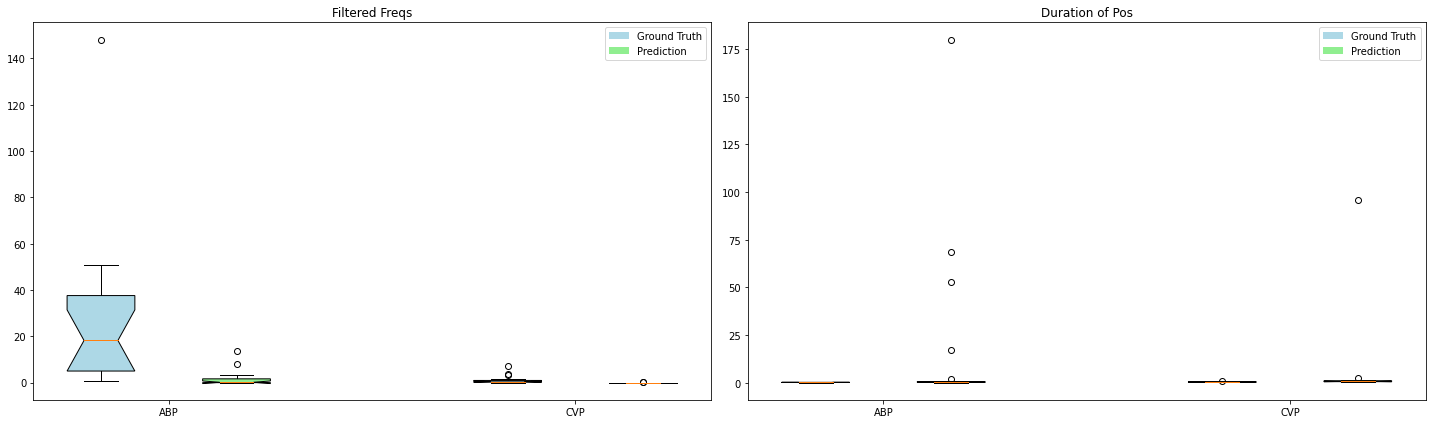

In [7]:
 plot_summary_metrics(stitched_predictions_abp, stitched_ground_truth_abp, stitched_predictions_cvp, stitched_ground_truth_cvp)

In [ ]:
# Example test predictions (start_time, end_time, score)
test_predictions = [(0, 10, 0.5), (10, 20, 0.7), (20, 30, 0.6)]

# Window size and slide length for the smoothing
window_size = 20
slide_len = 10

# Test the Gaussian smoothing
smoothed_predictions = smooth(test_predictions, window_size, slide_len, method="gaussian", sigma=1.0)

# Display the smoothed predictions
for pred in smoothed_predictions:
    print(pred)